In [13]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [14]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [15]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [16]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [17]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']

In [19]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import L1L2
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

# Assuming your data is already prepared: X_train_poly, X_validation_poly, y_train, etc.

# Initializing the Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling the input features
X_train_scaled = scaler.fit_transform(X_train_poly)
X_validation_scaled = scaler.transform(X_validation_poly)
X_test_scaled = scaler.transform(X_test_poly)

# LSTM Model adjustments
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1), recurrent_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dropout(0.3))  # Increased dropout rate
lstm_model.add(BatchNormalization())  # Added batch normalization
lstm_model.add(LSTM(units=50, recurrent_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dropout(0.3))  # Increased dropout rate
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Reshaping input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_validation_reshaped = X_validation_scaled.reshape((X_validation_scaled.shape[0], X_validation_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Implementing Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fitting the LSTM Model with Early Stopping
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_validation_reshaped, y_validation), callbacks=[early_stopping], verbose=0)

# XGB Model adjustments
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, reg_alpha=0.1, reg_lambda=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_set=[(X_validation_scaled, y_validation)], verbose=0)

# Predictions remain unchanged
lstm_pred = lstm_model.predict(X_test_reshaped)
xgb_pred = xgb_model.predict(X_test_scaled)


# Averaged Thresholds for price spike detection
# T1 = (T1_train + T1_test + T1_validation) / 3
# T2 = (T2_train + T2_test + T2_validation) / 3
# Averaged Thresholds for price spike detection
T1 = 71.54  # Average 75th percentile across datasets
T2 = 156.97  # Average 95th percentile across datasets

# Final price predictions based on the conditions described in the reference
final_predictions = np.where(lstm_pred.flatten() < T1, xgb_pred,
                            np.where(lstm_pred.flatten() < T2, lstm_pred.flatten(), xgb_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


45/45 [==============================] - 1s 4ms/step


In [ ]:
# Save models
lstm_model.save('/content/drive/MyDrive/Saved_trained_models/lstm_model.h5')
xgb_model.save_model('/content/drive/MyDrive/Saved_trained_models/xgb_model.json')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from keras.models import load_model
from xgboost import XGBRegressor

# Load models
lstm_model_loaded = load_model('/content/drive/MyDrive/Saved_trained_models/lstm_model.h5')
xgb_model_loaded = XGBRegressor()
xgb_model_loaded.load_model('/content/drive/MyDrive/Saved_trained_models/xgb_model.json')


In [22]:
from sklearn.preprocessing import MinMaxScaler
# Initializing the Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling the input features
X_train_scaled = scaler.fit_transform(X_train_poly)
X_validation_scaled = scaler.transform(X_validation_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Reshaping input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_validation_reshaped = X_validation_scaled.reshape((X_validation_scaled.shape[0], X_validation_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Make predictions with the loaded models for all datasets
lstm_train_pred_loaded = lstm_model_loaded.predict(X_train_reshaped).flatten()
lstm_validation_pred_loaded = lstm_model_loaded.predict(X_validation_reshaped).flatten()
lstm_test_pred_loaded = lstm_model_loaded.predict(X_test_reshaped).flatten()

xgb_train_pred_loaded = xgb_model_loaded.predict(X_train_scaled)
xgb_validation_pred_loaded = xgb_model_loaded.predict(X_validation_scaled)
xgb_test_pred_loaded = xgb_model_loaded.predict(X_test_scaled)
T1 = 71.54  # Average 75th percentile across datasets
T2 = 156.97  # Average 95th percentile across datasets


# Combine LSTM and XGB predictions based on thresholds
final_train_pred = np.where(lstm_train_pred_loaded < T1, xgb_train_pred_loaded,
                            np.where(lstm_train_pred_loaded < T2, lstm_train_pred_loaded, xgb_train_pred_loaded))

final_validation_pred = np.where(lstm_validation_pred_loaded < T1, xgb_validation_pred_loaded,
                                 np.where(lstm_validation_pred_loaded < T2, lstm_validation_pred_loaded, xgb_validation_pred_loaded))

final_test_pred = np.where(lstm_test_pred_loaded < T1, xgb_test_pred_loaded,
                           np.where(lstm_test_pred_loaded < T2, lstm_test_pred_loaded, xgb_test_pred_loaded))

# Evaluate on the training dataset
train_metrics = calculate_metrics(y_train, final_train_pred)
print('Training Metrics:')
print(f"MAE: {train_metrics[0]}")
print(f"MAPE: {train_metrics[1]}")
print(f"sMAPE: {train_metrics[2]}")
print(f"RMSE: {train_metrics[3]}\n")

# Evaluate on the validation dataset
validation_metrics = calculate_metrics(y_validation, final_validation_pred)
print('Validation Metrics:')
print(f"MAE: {validation_metrics[0]}")
print(f"MAPE: {validation_metrics[1]}")
print(f"sMAPE: {validation_metrics[2]}")
print(f"RMSE: {validation_metrics[3]}\n")

# Evaluate on the test dataset
test_metrics = calculate_metrics(y_test, final_test_pred)
print('Test Metrics:')
print(f"MAE: {test_metrics[0]}")
print(f"MAPE: {test_metrics[1]}")
print(f"sMAPE: {test_metrics[2]}")
print(f"RMSE: {test_metrics[3]}\n")


45/45 [==============================] - 0s 3ms/step
Training Metrics:
MAE: 8.584397987943797
MAPE: 14.724501683769295
sMAPE: 14.12946288195789
RMSE: 15.703276982461553

Validation Metrics:
MAE: 12.72175830312111
MAPE: 20.915194941402948
sMAPE: 21.736027986970598
RMSE: 24.391672892862026

Test Metrics:
MAE: 11.36146767254707
MAPE: 11.147575460298336
sMAPE: 15.513533252608982
RMSE: 27.217067167268763



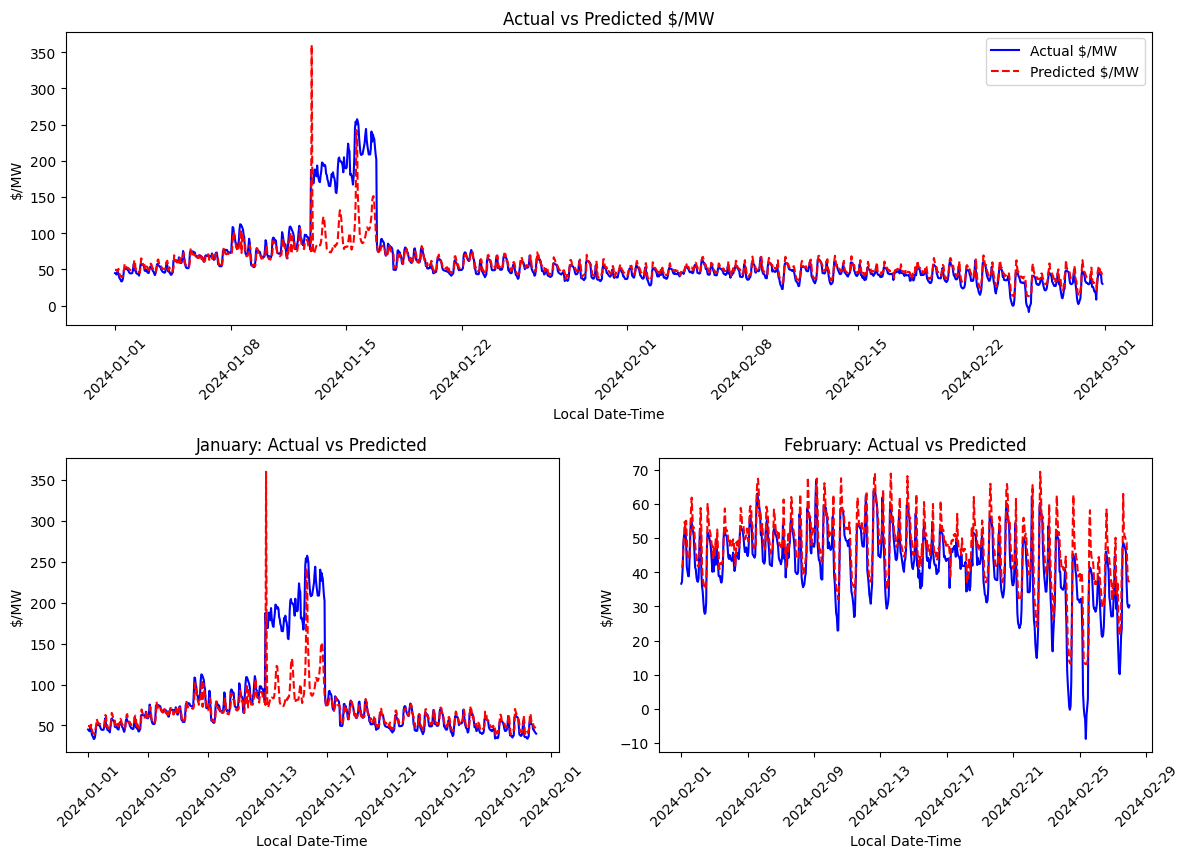

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(final_test_pred):
    test_local_time = test_local_time[:len(final_test_pred)]

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = final_test_pred[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = final_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, final_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()

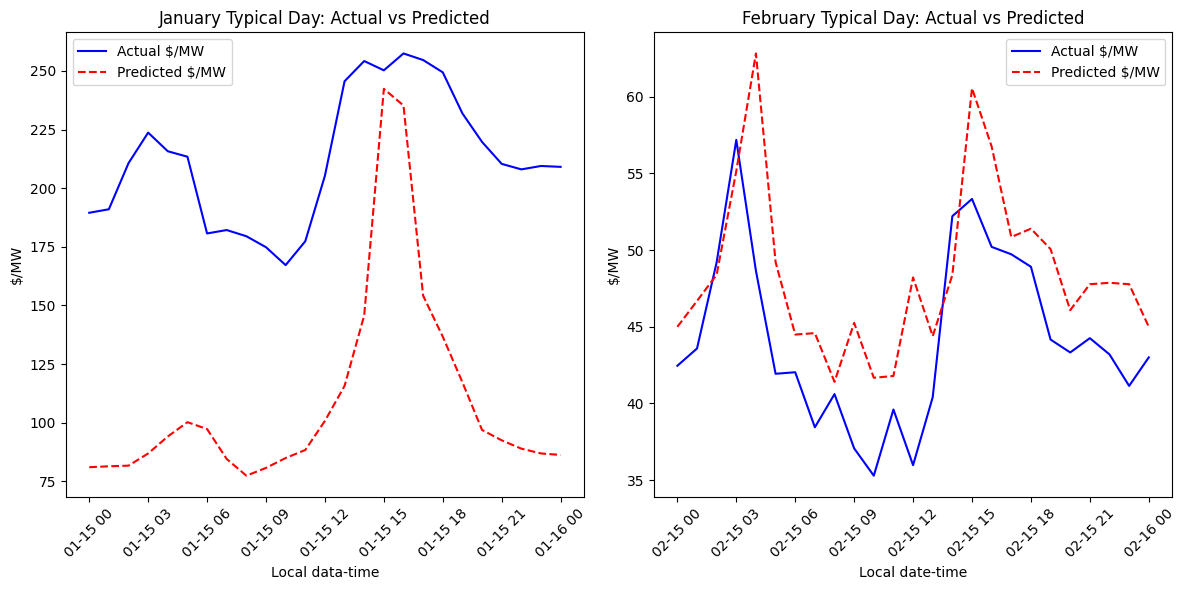

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = final_test_pred[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = final_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()


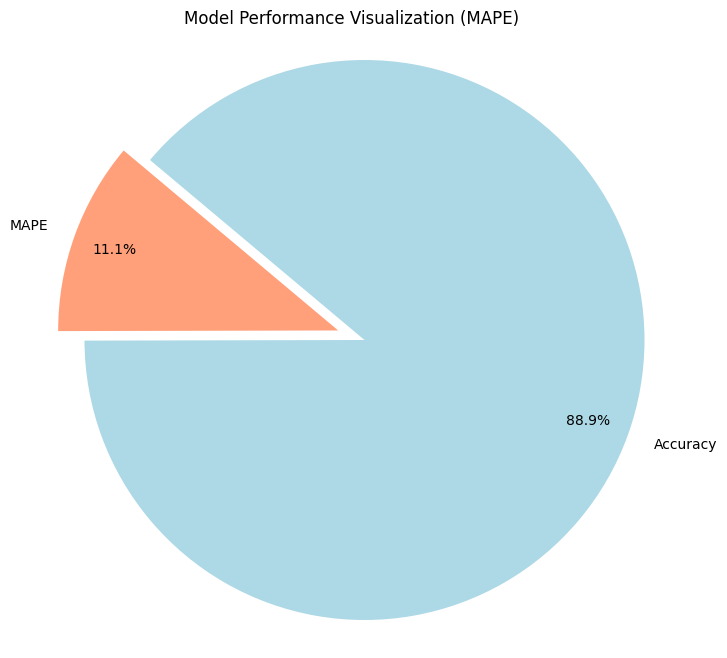

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_metrics is structured as [MAE, MAPE, sMAPE, RMSE]
mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()

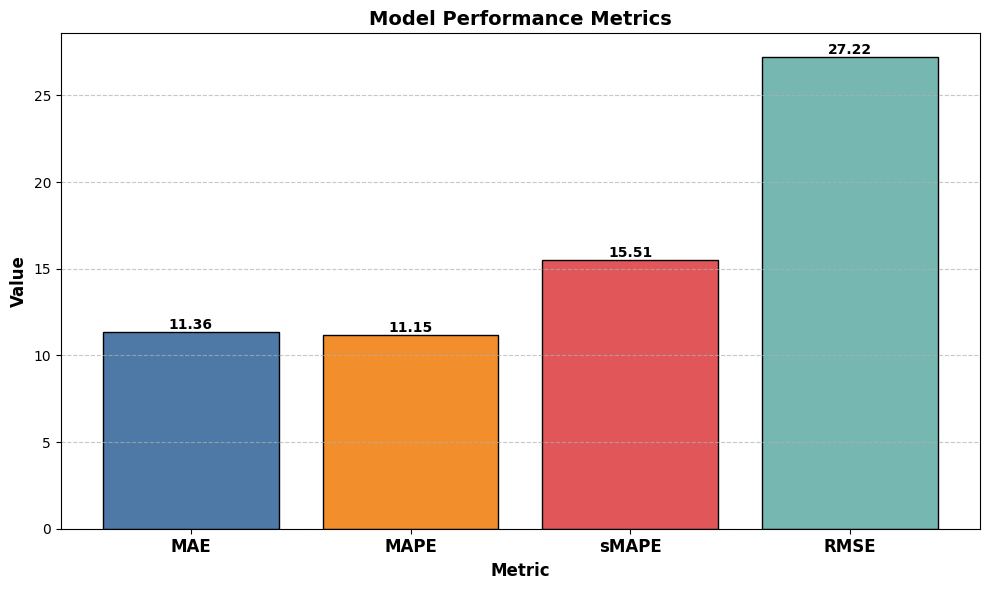

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

# Optional: Adding the value of each metric above its bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()